In [7]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
from scipy.special import legendre
from sklearn import metrics
import pandas as pd
import numpy as np
import logitboost as lb
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../db/clean_and_no_NaN/match_stats_with_wins.csv')

# df = pd.read_csv('../db/clean_and_no_NaN/wta_matches_clean.csv')

In [6]:
# ranksALL = ['match_id', 'date', 'name_P1', 'rank_points_P1', 'elo_P1',
#             'glicko_P1', 'name_P2', 'rank_points_P2', 'elo_P2', 'glicko_P2', 'y']


# ranksELO = ['match_id', 'date', 'name_P1',
#             'elo_P1', 'name_P2', 'elo_P2', 'glicko_P2', 'y']


# ranksGLICKO = ['match_id', 'date', 'name_P1',
#                'glicko_P1', 'name_P2', 'glicko_P2', 'y']

# ranksOFFICIAL = ['match_id', 'date', 'name_P1',
#                  'name_P2', 'y', 'win_percentage_PVP_P1', 'win_percentage_PVP_P2', 'ace_probability_PVP_P1', 'ace_probability_PVP_P2']


# df = df[ranksOFFICIAL]

# print(df['name_P1'].unique())


# df.describe()

In [3]:
testp1 = df.filter(regex='_P1_vs$', axis=1)

testp2 = df.filter(regex='_P2_vs$', axis=1)


feats = list(zip(testp1.columns, testp2.columns))


for col_a, col_b in feats:
    df[col_a + '_diff'] = df[col_a] - df[col_b]

df.drop(testp1.columns, axis=1, inplace=True)

df.drop(testp2.columns, axis=1, inplace=True)

non_numeric_columns = df.select_dtypes(['object']).columns

df = df.drop(non_numeric_columns, axis=1)

testp1 = df.filter(regex='_P1$', axis=1)

testp2 = df.filter(regex='_P2$', axis=1)

feats = list(zip(testp1.columns, testp2.columns))

for col_a, col_b in feats:
    df[col_a + '_diff'] = df[col_a] - df[col_b]

df.drop(testp1.columns, axis=1, inplace=True)

df.drop(testp2.columns, axis=1, inplace=True)

In [4]:
non_numeric_columns = df.select_dtypes(['object']).columns

df_numeric_only = df.drop(non_numeric_columns, axis=1)

df = df_numeric_only

df_numeric_only_not_normalized = df_numeric_only

df = df.fillna(df.median())


def normalize(dff):
    result = dff.copy()
    for feature_name in dff.columns:
        max_value = dff[feature_name].max()
        min_value = dff[feature_name].min()
        result[feature_name] = (
            dff[feature_name] - min_value) / (max_value - min_value)
    return result


df = normalize(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36041 entries, 0 to 36040
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   match_id                          36041 non-null  float64
 1   draw_size                         36041 non-null  float64
 2   y                                 36041 non-null  float64
 3   rank_points_P1_diff               36041 non-null  float64
 4   elo_P1_diff                       36041 non-null  float64
 5   glicko_P1_diff                    36041 non-null  float64
 6   ht_P1_diff                        36041 non-null  float64
 7   age_P1_diff                       36041 non-null  float64
 8   games_played_P1_diff              36041 non-null  float64
 9   win_percentage_P1_diff            36041 non-null  float64
 10  surface_wins_P1_diff              36041 non-null  float64
 11  bp_factor_P1_diff                 36041 non-null  float64
 12  firs

# Tutaj przygotowoanie danych do modelu


In [5]:
Y = pd.DataFrame(df['y'])
df = df.drop(['y'], axis=1)
X = df
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=18, stratify=Y)

Logistic Regression


In [16]:
# Define model
model = LogisticRegression()
# model = RFE(model, n_features_to_select=5, step=1)

param_grid = {
    'C': np.logspace(0, 4, num=10),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'sag', 'newton-cg']
}

search = RandomizedSearchCV(model, param_grid, n_iter=10,
                            cv=10, scoring='accuracy', n_jobs=-1, random_state=1, verbose=2)

result = search.fit(X_train, y_train)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
best_random = result.best_estimator_

y_pred_test = best_random.predict(X_test)
print(classification_report(y_test, y_pred_test))

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Score: 0.6795933452738157
Best Hyperparameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 464.15888336127773}


In [35]:
# Prediction with best model from random search

              precision    recall  f1-score   support

         0.0       0.68      0.66      0.67      3547
         1.0       0.68      0.70      0.69      3662

    accuracy                           0.68      7209
   macro avg       0.68      0.68      0.68      7209
weighted avg       0.68      0.68      0.68      7209



Drzewo decyzyjne


In [10]:
from sklearn.tree import DecisionTreeClassifier

# Define model
model = DecisionTreeClassifier(max_depth=10, random_state=75)


param_grid = {
    'max_depth': list(range(5, 20, 1)),
    'max_features': ['auto', 'sqrt', 'log2']
}

search = RandomizedSearchCV(model, param_grid, n_iter=15,
                            cv=10, scoring='accuracy', n_jobs=-1, random_state=1, verbose=2)

# search = RFE(model, n_features_to_select=5, step=1)

# execute search
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
Best Score: 0.6593030044120131
Best Hyperparameters: {'max_features': 'log2', 'max_depth': 5}


: 

In [25]:
from sklearn.tree import export_graphviz

export_graphviz(model, out_file='tree.dot',
                feature_names=X_train.columns, class_names=['0', '1'], rounded=True, filled=True)

In [28]:
# from graphviz import Source

# Source.from_file('tree.dot')

In [24]:
# Prediction with best model from random search
# best_random = result.best_estimator_

y_pred_test = model.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.66      0.65      0.65      3547
         1.0       0.66      0.67      0.67      3662

    accuracy                           0.66      7209
   macro avg       0.66      0.66      0.66      7209
weighted avg       0.66      0.66      0.66      7209



Las losowy


In [29]:
model = RandomForestClassifier()

# define evaluation
# gkf = GroupKFold(n_splits=3) if not spec as cv= in the randomized search default is 5 fold cv

# define search space
param_grid = {
    'max_depth': list(range(5, 25, 2)),
    'n_estimators': list(range(80, 200, 10)),
    'criterion': ['gini', 'entropy'],
}

search = RandomizedSearchCV(model, param_grid, n_iter=15,
                            cv=10, scoring='accuracy', n_jobs=-1, random_state=1, verbose=2)

# execute search
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
Best Score: 0.6794543723958371
Best Hyperparameters: {'n_estimators': 180, 'max_depth': 9, 'criterion': 'gini'}


In [30]:
# Prediction with best model from random search
best_random = result.best_estimator_

y_pred_test = best_random.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.68      0.68      0.68      3547
         1.0       0.69      0.69      0.69      3662

    accuracy                           0.68      7209
   macro avg       0.68      0.68      0.68      7209
weighted avg       0.68      0.68      0.68      7209



ADABoost


In [20]:
model = AdaBoostClassifier()

# define evaluation
# gkf = GroupKFold(n_splits=3) if not spec as cv= in the randomized search default is 5 fold cv

# define search space
param_grid = {
    'n_estimators': list(range(80, 200, 10))
}

search = RandomizedSearchCV(model, param_grid, n_iter=5,
                            cv=10, scoring='accuracy', n_jobs=-1, random_state=1, verbose=2)

# execute search
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best Score: 0.6776853216256953
Best Hyperparameters: {'n_estimators': 120}


In [21]:
# Prediction with best model from random search
best_random = result.best_estimator_

y_pred_test = best_random.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67      3547
         1.0       0.68      0.68      0.68      3662

    accuracy                           0.68      7209
   macro avg       0.68      0.68      0.68      7209
weighted avg       0.68      0.68      0.68      7209



# Logit boost


In [22]:
model = lb.LogitBoost()

# define search space
param_grid = {'n_estimators': list(range(80, 200, 10))
              }

search = RandomizedSearchCV(model, param_grid, n_iter=5,
                            cv=10, scoring='accuracy', n_jobs=-1, random_state=1)

# execute search
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.6776161418771767
Best Hyperparameters: {'n_estimators': 100}


In [23]:
# Prediction with best model from random search
best_random = result.best_estimator_

y_pred_test = best_random.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67      3547
         1.0       0.68      0.68      0.68      3662

    accuracy                           0.67      7209
   macro avg       0.67      0.67      0.67      7209
weighted avg       0.67      0.67      0.67      7209



# SVM


In [9]:
from sklearn import metrics
from sklearn import svm

# Create a svm Classifier
model = svm.SVC(kernel='linear')  # Linear Kernel

# Train the model using the training sets

param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}


search = RandomizedSearchCV(model, param_grid, n_iter=5,
                            cv=10, scoring='accuracy', n_jobs=-1, random_state=1)

# execute search
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Accuracy: 0.6792897766680538


# ANN


In [21]:
# import tensorflow
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras import Input
from keras.layers import Dropout
from keras.layers import Dense
from keras.callbacks import History

history = History()

# use keras API
tf.random.set_seed(49)
model = tf.keras.Sequential()

# determine the number of input features
n_features = X_train.shape[1]
# define model
model = Sequential()
model.add(Input(shape=X_train.shape[1]))
model.add(Dense(300, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.4))
model.add(Dense(200, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(100, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.6))
model.add(Dense(100, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 300)               6900      
                                                                 
 dropout_12 (Dropout)        (None, 300)               0         
                                                                 
 dense_25 (Dense)            (None, 100)               30100     
                                                                 
 dropout_13 (Dropout)        (None, 100)               0         
                                                                 
 dense_26 (Dense)            (None, 100)               10100     
                                                                 
 dropout_14 (Dropout)        (None, 100)               0         
                                                                 
 dense_27 (Dense)            (None, 1)               

In [25]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, batch_size=128, callbacks=[
                    history], validation_split=0.2)
test_loss, test_acc = model.evaluate(X_test, y_test)

Epoch 1/100
181/181 [==============================] - 1s 4ms/step - loss: 0.6295 - accuracy: 0.6509 - val_loss: 0.6130 - val_accuracy: 0.6761
Epoch 2/100
181/181 [==============================] - 1s 3ms/step - loss: 0.6299 - accuracy: 0.6481 - val_loss: 0.6144 - val_accuracy: 0.6754
Epoch 3/100
181/181 [==============================] - 1s 3ms/step - loss: 0.6255 - accuracy: 0.6550 - val_loss: 0.6160 - val_accuracy: 0.6728
Epoch 4/100
181/181 [==============================] - 1s 3ms/step - loss: 0.6285 - accuracy: 0.6476 - val_loss: 0.6160 - val_accuracy: 0.6731
Epoch 5/100
181/181 [==============================] - 1s 3ms/step - loss: 0.6272 - accuracy: 0.6517 - val_loss: 0.6143 - val_accuracy: 0.6735
Epoch 6/100
181/181 [==============================] - 1s 3ms/step - loss: 0.6266 - accuracy: 0.6523 - val_loss: 0.6133 - val_accuracy: 0.6775
Epoch 7/100
181/181 [==============================] - 1s 3ms/step - loss: 0.6282 - accuracy: 0.6507 - val_loss: 0.6129 - val_accuracy: 0.6761

In [23]:
y_pred_test = model.predict(X_test)
y_pred_test = [int(i > .5) for i in y_pred_test]

print(classification_report(y_test, y_pred_test))

226/226 [==============================] - 0s 921us/step
              precision    recall  f1-score   support

         0.0       0.64      0.74      0.69      3547
         1.0       0.70      0.59      0.64      3662

    accuracy                           0.67      7209
   macro avg       0.67      0.67      0.67      7209
weighted avg       0.67      0.67      0.66      7209



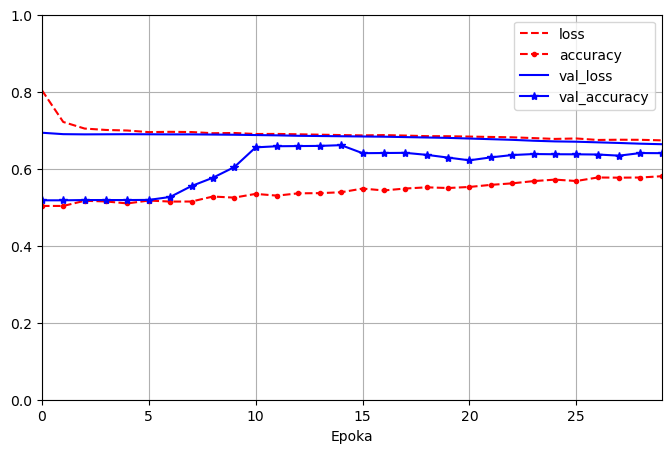

In [26]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoka",
    style=["r--", "r--.", "b-", "b-*"])
plt.show()

# StackingClassifier


In [10]:
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=2  # liczba podzbiorów sprawdzianu krzyżowego
)
result = stacking_clf.fit(X_train, y_train)

print('Best Score: %s' % result.score(X_test, y_test))
print('Best Hyperparameters: %s' % result.get_params())


# Prediction with best model from random search
# best_random = result.best_estimator_

print(classification_report(y_test, y_pred_test))

Best Score: 0.6437786100707449
Best Hyperparameters: {'cv': 2, 'estimators': [('lr', LogisticRegression(random_state=42)), ('rf', RandomForestClassifier(random_state=42)), ('svc', SVC(probability=True, random_state=42))], 'final_estimator__bootstrap': True, 'final_estimator__ccp_alpha': 0.0, 'final_estimator__class_weight': None, 'final_estimator__criterion': 'gini', 'final_estimator__max_depth': None, 'final_estimator__max_features': 'sqrt', 'final_estimator__max_leaf_nodes': None, 'final_estimator__max_samples': None, 'final_estimator__min_impurity_decrease': 0.0, 'final_estimator__min_samples_leaf': 1, 'final_estimator__min_samples_split': 2, 'final_estimator__min_weight_fraction_leaf': 0.0, 'final_estimator__n_estimators': 100, 'final_estimator__n_jobs': None, 'final_estimator__oob_score': False, 'final_estimator__random_state': 43, 'final_estimator__verbose': 0, 'final_estimator__warm_start': False, 'final_estimator': RandomForestClassifier(random_state=43), 'n_jobs': None, 'passt

NameError: name 'best_random' is not defined